# Preparación

In [1]:
from ETL_pg2neo4j.diagnostics import get_machine_stats
from ETL_pg2neo4j.spark_session import get_spark
from ETL_pg2neo4j.load_config import (
    NEO4J_URI, NEO4J_USER, NEO4J_PASS, NEO4J_DDBB
)

# 1) Detectar recursos de la máquina
stats = get_machine_stats()

# 2) Crear SparkSession con jars de Postgres + Neo4j ya configurados
spark, jdbc_props = get_spark(stats)

# (Opcional) Verifica rápidamente
spark.version, stats


[SPARK] usando jars locales -> /opt/spark/extra-jars/postgresql-42.7.4.jar,/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar
[SPARK] classpath reforzado (driver/executors) -> /opt/spark/extra-jars/postgresql-42.7.4.jar:/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar


ERROR StatusLogger Reconfiguration failed: No configuration found for '5ffd2b27' at 'null' in 'null'
ERROR StatusLogger Reconfiguration failed: No configuration found for 'Default' at 'null' in 'null'
25/11/23 14:29:15 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp2s0)
25/11/23 14:29:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/23 14:29:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 14:29:16 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[CHECK] Postgres JDBC REALMENTE visible
[CHECK] Neo4j connector REALMENTE visible


('3.5.3',
 {'cpu_cores': 8,
  'mem_total_bytes': 16644382720,
  'mem_used_bytes': 12503138304,
  'mem_available_bytes': 4141244416})

In [2]:
# Query Cypher para nodos: trae solo lo que te interesa ahora
node_query = """
MATCH (a:Account)
RETURN
    id(a)                  AS neo4j_id,
    a.account_number       AS account_number,
    a.location             AS location,
    a.current_balance      AS current_balance,
    a.first_seen           AS first_seen,
    a.last_seen            AS last_seen
"""

nodes_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", node_query)
        .load()
)

nodes_df.printSchema()
nodes_df.show(5)


root
 |-- neo4j_id: long (nullable = true)
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)

+--------+--------------+--------+------------------+-------------------+-------------------+
|neo4j_id|account_number|location|   current_balance|         first_seen|          last_seen|
+--------+--------------+--------+------------------+-------------------+-------------------+
|       0|    4651102136|      UK|51445.619999999995|2023-03-17 21:35:31|2023-03-18 18:45:28|
|       1|    3647155427|      UK|         -68020.94|2023-03-10 06:34:09|2023-03-10 20:02:05|
|       2|    8986636663|      UK|2804.2599999999998|2022-10-27 06:16:50|2023-05-20 08:41:51|
|       3|     196361780|      UK|         131638.48|2022-10-17 16:03:31|2023-07-07 13:12:55|
|       4|    3775525103|      UK|           15667.7|2022-11-06 08:09:43|2023-

In [3]:
edge_query = """
MATCH (src:Account)-[r:TX]->(dst:Account)
RETURN
    id(r)                        AS neo4j_rel_id,
    r.id                         AS id,
    src.account_number           AS src,
    dst.account_number           AS dst,
    r.timestamp                  AS timestamp,
    r.amount                     AS amount,
    r.payment_currency           AS payment_currency,
    r.received_currency          AS received_currency,
    r.payment_type               AS payment_type,
    r.is_laundering              AS is_laundering,
    r.laundering_type            AS laundering_type,
    r.masked                     AS masked,
    r.src_delta                  AS src_delta,
    r.src_balance_before         AS src_balance_before,
    r.src_balance_after          AS src_balance_after,
    r.src_seq                    AS src_seq,
    r.src_currency               AS src_currency,
    r.dst_delta                  AS dst_delta,
    r.dst_balance_before         AS dst_balance_before,
    r.dst_balance_after          AS dst_balance_after,
    r.dst_seq                    AS dst_seq,
    r.dst_currency               AS dst_currency
"""

edges_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", edge_query)
        .load()
)

edges_df.printSchema()
edges_df.show(5)


root
 |-- neo4j_rel_id: long (nullable = true)
 |-- id: long (nullable = true)
 |-- src: long (nullable = true)
 |-- dst: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- amount: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- received_currency: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- is_laundering: long (nullable = true)
 |-- laundering_type: string (nullable = true)
 |-- masked: long (nullable = true)
 |-- src_delta: double (nullable = true)
 |-- src_balance_before: double (nullable = true)
 |-- src_balance_after: double (nullable = true)
 |-- src_seq: long (nullable = true)
 |-- src_currency: string (nullable = true)
 |-- dst_delta: double (nullable = true)
 |-- dst_balance_before: double (nullable = true)
 |-- dst_balance_after: double (nullable = true)
 |-- dst_seq: long (nullable = true)
 |-- dst_currency: string (nullable = true)

+-------------------+-------+----------+----------+------------

# Grados y hubs

## Métricas básicas por nodo

In [4]:
from pyspark.sql import functions as F

# --- OUT: métricas como emisor (src) ---
out_stats = (
    edges_df
    .groupBy("src")
    .agg(
        F.count("*").alias("out_degree"),
        F.sum("amount").alias("out_amount_sum"),
        F.sum("is_laundering").alias("fraud_out_count")  # is_laundering es 0/1
    )
)

# --- IN: métricas como receptor (dst) ---
in_stats = (
    edges_df
    .groupBy("dst")
    .agg(
        F.count("*").alias("in_degree"),
        F.sum("amount").alias("in_amount_sum"),
        F.sum("is_laundering").alias("fraud_in_count")
    )
)


In [7]:
# Partimos de los atributos "básicos" que sí nos interesan
base_nodes = nodes_df.select(
    "account_number",
    "location",
    "current_balance",
    "first_seen",
    "last_seen"
)

node_metrics_df = (
    base_nodes
    # join con estadísticas de salida
    .join(out_stats, base_nodes.account_number == out_stats.src, "left")
    # join con estadísticas de entrada
    .join(in_stats, base_nodes.account_number == in_stats.dst, "left")
    .drop("src", "dst")
)

# Rellenar los nulls (cuentas que nunca emitieron/recibieron algo) con 0
numeric_cols = [
    "out_degree", "out_amount_sum", "fraud_out_count",
    "in_degree", "in_amount_sum", "fraud_in_count"
]

for c in numeric_cols:
    node_metrics_df = node_metrics_df.withColumn(
        c, F.coalesce(F.col(c), F.lit(0.0))
    )

# Cast a tipos más "bonitos" donde toque (los counts como long/int)
node_metrics_df = (
    node_metrics_df
    .withColumn("out_degree", F.col("out_degree").cast("long"))
    .withColumn("in_degree", F.col("in_degree").cast("long"))
    .withColumn("fraud_out_count", F.col("fraud_out_count").cast("long"))
    .withColumn("fraud_in_count", F.col("fraud_in_count").cast("long"))
)


In [8]:
node_metrics_df = (
    node_metrics_df
    .withColumn(
        "fraud_out_ratio",
        F.when(F.col("out_degree") > 0,
               F.col("fraud_out_count") / F.col("out_degree"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "fraud_in_ratio",
        F.when(F.col("in_degree") > 0,
               F.col("fraud_in_count") / F.col("in_degree"))
         .otherwise(F.lit(0.0))
    )
)


## Vecinos y vecinos fraudulentos

In [9]:
#Vecinos totales
# Aristas no dirigidas (a,b) y (b,a), sin duplicados
edges_undirected = (
    edges_df
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df.select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

neighbors = (
    edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("neighbors_count"))
)


In [10]:
#Vecinos con al menos un enlace fraudulento
fraud_edges_undirected = (
    edges_df
    .filter(F.col("is_laundering") == 1)
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df
        .filter(F.col("is_laundering") == 1)
        .select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

fraud_neighbors = (
    fraud_edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("fraud_neighbors_count"))
)


In [11]:
node_metrics_df = (
    node_metrics_df
    .join(neighbors, node_metrics_df.account_number == neighbors.a, "left")
    .join(fraud_neighbors, node_metrics_df.account_number == fraud_neighbors.a, "left")
    .drop("a")
)

node_metrics_df = (
    node_metrics_df
    .withColumn("neighbors_count", F.coalesce(F.col("neighbors_count"), F.lit(0)))
    .withColumn("fraud_neighbors_count", F.coalesce(F.col("fraud_neighbors_count"), F.lit(0)))
    .withColumn(
        "fraud_neighbors_ratio",
        F.when(F.col("neighbors_count") > 0,
               F.col("fraud_neighbors_count") / F.col("neighbors_count"))
         .otherwise(F.lit(0.0))
    )
)


## Análisis

In [12]:
node_metrics_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)


25/11/23 14:58:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 26:>                                                         (0 + 1) / 1]

+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|summary|in_degree         |out_degree        |in_amount_sum     |out_amount_sum   |fraud_in_ratio       |fraud_out_ratio    |neighbors_count   |fraud_neighbors_ratio|
+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|count  |855460            |855460            |855460            |855460           |855460               |855460             |855460            |855460               |
|mean   |11.110808220138873|11.110808220138873|97363.65245319254 |97363.65245319293|0.0015532081593782822|3.79021782102301E-4|1.9652116989689759|0.0018401598192986234|
|stddev |27.02063620269903 |55.75791563599599 |281141.07274827536|459051.6994912461|0.03469331988431024  |0.01035075493637477|6.494315089979579 |0.0329752019288

In [13]:
deg_dist = (
    node_metrics_df
    .withColumn(
        "out_degree_bin",
        F.when(F.col("out_degree") == 0, "0")
         .otherwise(
             F.concat(
                 F.lit("1e"),
                 F.floor(F.log10("out_degree")).cast("int")  # 1e0, 1e1, 1e2...
             )
         )
    )
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

deg_dist.show(truncate=False)


+--------------+------+
|out_degree_bin|count |
+--------------+------+
|0             |562745|
|1e0           |75997 |
|1e1           |198174|
|1e2           |18544 |
+--------------+------+



In [14]:
def add_degree_bins(df, col_name, bin_col_name):
    return (
        df.withColumn(
            bin_col_name,
            F.when(F.col(col_name) == 0, "0")
             .when(F.col(col_name) == 1, "1")
             .when((F.col(col_name) >= 2) & (F.col(col_name) <= 5), "2–5")
             .when((F.col(col_name) >= 6) & (F.col(col_name) <= 10), "6–10")
             .when((F.col(col_name) >= 11) & (F.col(col_name) <= 20), "11–20")
             .when((F.col(col_name) >= 21) & (F.col(col_name) <= 50), "21–50")
             .when((F.col(col_name) >= 51) & (F.col(col_name) <= 100), "51–100")
             .when((F.col(col_name) >= 101) & (F.col(col_name) <= 200), "101–200")
             .otherwise(">200")
        )
    )

# Añadimos bins para in/out degree
node_binned_df = (
    node_metrics_df
    .transform(lambda df: add_degree_bins(df, "out_degree", "out_degree_bin"))
    .transform(lambda df: add_degree_bins(df, "in_degree", "in_degree_bin"))
)

# Distribución de out_degree
out_deg_dist_spark = (
    node_binned_df
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

# Distribución de in_degree
in_deg_dist_spark = (
    node_binned_df
    .groupBy("in_degree_bin")
    .count()
    .orderBy("in_degree_bin")
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


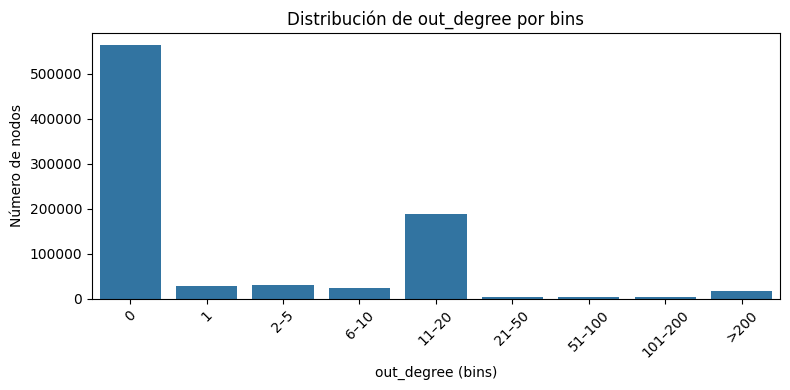

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


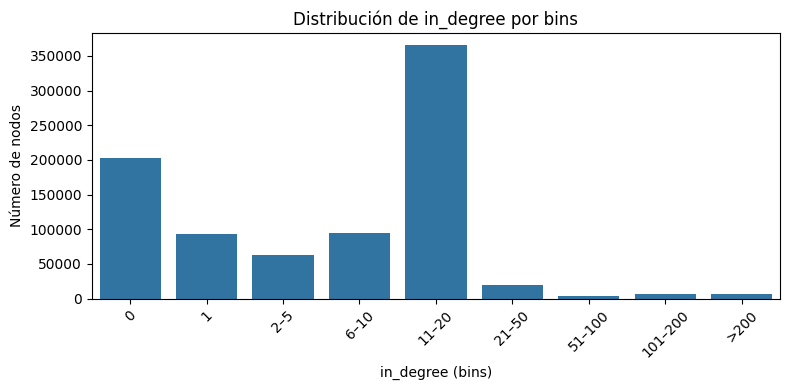

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

deg_bins_order = ["0", "1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–200", ">200"]

# OUT DEGREE
out_deg_dist = out_deg_dist_spark.toPandas()
cat_type_out = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
out_deg_dist["out_degree_bin"] = out_deg_dist["out_degree_bin"].astype(cat_type_out)
out_deg_dist = out_deg_dist.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=out_deg_dist,
    x="out_degree_bin",
    y="count"
)
plt.title("Distribución de out_degree por bins")
plt.xlabel("out_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# IN DEGREE
in_deg_dist = in_deg_dist_spark.toPandas()
cat_type_in = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
in_deg_dist["in_degree_bin"] = in_deg_dist["in_degree_bin"].astype(cat_type_in)
in_deg_dist = in_deg_dist.sort_values("in_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=in_deg_dist,
    x="in_degree_bin",
    y="count"
)
plt.title("Distribución de in_degree por bins")
plt.xlabel("in_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# Tomar, por ejemplo, el 10% de los nodos (o un límite de filas)
sample_df = node_metrics_df.sample(withReplacement=False, fraction=0.1, seed=42)

sample_pd = sample_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).toPandas()

sample_pd.describe(percentiles=[0.25, 0.5, 0.75]).T  # se ve muy legible en Jupyter


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,count,mean,std,min,25%,50%,75%,max
in_degree,85828.0,11.104814,27.028108,0.0,1.0000,9.00,13.0000,7.300000e+02
out_degree,85828.0,11.063301,55.584429,0.0,0.0000,0.00,10.0000,7.420000e+02
in_amount_sum,85828.0,98179.820361,283783.671475,0.0,942.6725,23739.39,99034.6700,1.439340e+07
out_amount_sum,85828.0,97172.025458,459192.580207,0.0,0.0000,0.00,59270.7625,1.372392e+07
fraud_in_ratio,85828.0,0.001657,0.036405,0.0,0.0000,0.00,0.0000,1.000000e+00
fraud_out_ratio,85828.0,0.000367,0.009102,0.0,0.0000,0.00,0.0000,6.666667e-01
neighbors_count,85828.0,1.960596,6.465982,1.0,1.0000,1.00,1.0000,7.600000e+01
fraud_neighbors_ratio,85828.0,0.001972,0.034782,0.0,0.0000,0.00,0.0000,1.000000e+00


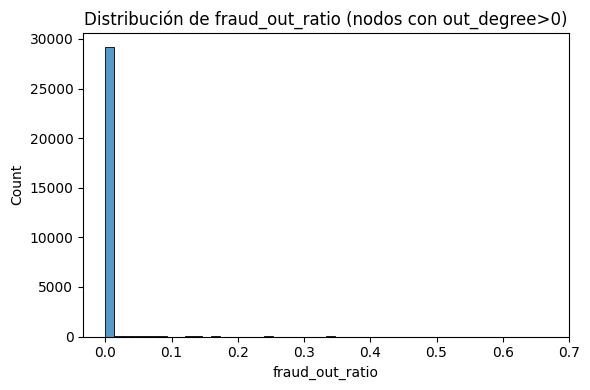

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=sample_pd[sample_pd["out_degree"] > 0], 
    x="fraud_out_ratio",
    bins=50
)
plt.title("Distribución de fraud_out_ratio (nodos con out_degree>0)")
plt.tight_layout()
plt.show()

Más de 500k cuentas con out_degree 0, nunca envían dinero. El resto se reparte en bins crecientes con solo una minoría de con out_degree alto. La moda del set es que las cuentas envíen entre 11 a 20 transferencias si es que son activas. La mayoría (moda real) no lo son.

Muchísima más masa hasta las 20 transacciones. Recibir dinero es mucho más común que enviarlo. El promedio de vecinos por nodo es de 2 por lo que la conectividad parece pequeña.

Ratios de fraude (fraud_in_ratio, fraud_out_ratio) tienen medias bajísimas, pero con colas que llegan a 1 lo que implica que hay cuentas completamente asociadas a fraude. Esto valida los hubs elegidos en el EDA temporal. Sin embargo, ese ejercicio carece de peso estadístico por la baja cantidad de hubs elegidos. Aún así, es un buen ejercicio, pues señala diferencias entre nodos y nodos.

# Conectividad y componentes

# Centralidades (degree, betweenness, PageRank…)

# Comunidades y “subredes calientes”

# Motifs y patrones AML clásicos

# De EDA topológico a features y clasificación nodal